# Time Series Prediction with Lorrenz Attractor Inspired Deep Learning ($LPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-11 19:54:56

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_SAN JUAN_

In [3]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

461
1       0.142857
2      -0.142857
3      -0.142857
4       0.428571
5      -0.571429
          ...   
1191   -1.000000
1192   -1.428571
1193    0.857143
1194   -2.571429
1195   -1.285714
Name: Cases, Length: 1195, dtype: float64
2      -0.040816
3       0.000000
4       0.081633
5      -0.142857
6       0.122449
          ...   
1191   -0.081633
1192   -0.061224
1193    0.326531
1194   -0.489796
1195    0.183673
Name: Cases, Length: 1194, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.142857
1      -0.142857
2      -0.142857
3       0.428571
4      -0.571429
          ...   
1190   -1.000000
1191   -1.428571
1192    0.857143
1193   -2.571429
1194   -1.285714
Name: Cases, Length: 1195, dtype: float64
0      -0.040816
1       0.000000
2       0.081633
3      -0.142857
4       0.122449
          ...   
1189   -0.081633
1190   -0.061224
1191    0.326531
1192   -0.489796
1193    0.183673
Name: Cases, Length: 1194, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(1195,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lorrenz Equation_)

_Parameters_: $\sigma=10, \rho=28$

<AxesSubplot:>

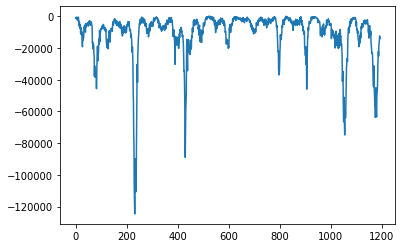

In [7]:
s=10
r=28
L = df.iloc[:, 2] + df.iloc[:, 1]*(1 + s) - df.iloc[:, 0] * s * (r - 1)
L.plot()

## Preprocessing the Data into Supervised Learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.0        5.0        4.0        3.0        6.0        2.0   
11         5.0        4.0        3.0        6.0        2.0        4.0   
12         4.0        3.0        6.0        2.0        4.0        5.0   
13         3.0        6.0        2.0        4.0        5.0       10.0   
14         6.0        2.0        4.0        5.0       10.0        6.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10        4.0        5.0       10.0        6.0      8.0 -0.857143  0.204082  
11        5.0       10.0        6.0        8.0      2.0  0.571429  0.142857  
12       10.0        6.0        8.0        2.0      6.0  1.571429 -0.102041  
13        6.0        8.0        2.0        6.0     17.0  0.857143 -0.326531  
14        8.0        2.0        6.0       17.0     23.0 -1.428571  0.367347  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(947, 1, 10) (947, 3) (237, 1, 10) (237, 3)


## Defining the Physical Loss

In [10]:
s = tf.Variable(10, name="sigma", trainable=True, dtype=tf.float32)
r = tf.Variable(28, name="rhow", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] + y_true[:, 1]*(1 + s) - y_true[:, 0] * s * (r - 1)), (y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] + (y_pred[1:-1]-y_pred[:-2])*(1 + s) - y_pred[:-2] * s * (r - 1)
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] + (y_real[1:-1]-y_real[:-2])*(1 + s) - y_real[:-2] * s * (r - 1)
    return(mean_absolute_error(pred, real))

## Model ($LPINN$)

In [11]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
15/15 - 8s - loss: 2.4190 - val_loss: 0.3507 - 8s/epoch - 525ms/step
Epoch 2/500
15/15 - 0s - loss: 0.3990 - val_loss: 0.3811 - 102ms/epoch - 7ms/step
Epoch 3/500
15/15 - 0s - loss: 0.3067 - val_loss: 0.2077 - 101ms/epoch - 7ms/step
Epoch 4/500
15/15 - 0s - loss: 0.1473 - val_loss: 0.1785 - 101ms/epoch - 7ms/step
Epoch 5/500
15/15 - 0s - loss: 0.1222 - val_loss: 0.1658 - 102ms/epoch - 7ms/step
Epoch 6/500
15/15 - 0s - loss: 0.1175 - val_loss: 0.1571 - 109ms/epoch - 7ms/step
Epoch 7/500
15/15 - 0s - loss: 0.1052 - val_loss: 0.1502 - 104ms/epoch - 7ms/step
Epoch 8/500
15/15 - 0s - loss: 0.0977 - val_loss: 0.1432 - 115ms/epoch - 8ms/step
Epoch 9/500
15/15 - 0s - loss: 0.0945 - val_loss: 0.1375 - 119ms/epoch - 8ms/step
Epoch 10/500
15/15 - 0s - loss: 0.0877 - val_loss: 0.1313 - 110ms/epoch - 7ms/step
Epoch 11/500
15/15 - 0s - loss: 0.0823 - val_loss: 0.1252 - 104ms/epoch - 7ms/step
Epoch 12/500
15/15 - 0s - loss: 0.0786 - val_loss: 0.1203 - 102ms/epoch - 7ms/step
Epoch 13/500
1

## Metrics ($LPINN$)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

8/8 [==============================] - 1s 8ms/step
(237, 3)
(237, 10)
Test RMSE: 85.563
Test MAE: 58.938


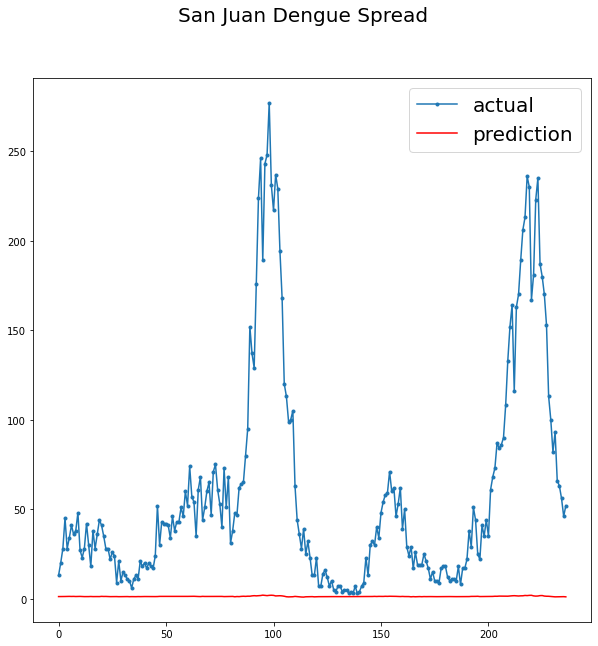

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()